#INITIAL SET UP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
  # Fix randomness and hide warnings

  seed = 42

  import os
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

  import warnings
  warnings.simplefilter(action='ignore', category=FutureWarning)
  warnings.simplefilter(action='ignore', category=Warning)

  import numpy as np
  np.random.seed(seed)

  import logging

  import random
  random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import cv2
from keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# DATA LOADING

In [ ]:
# Load the dataset
dataset = np.load('/content/drive/MyDrive/public_data/public_data.npz', allow_pickle=True)

print(dataset.files)

['data', 'labels']


In [ ]:
# Extract the arrays from the data
data = dataset['data']
labels = dataset['labels']

# Convert data and labels values into the correct data_type
data = np.array(data, dtype=np.uint8)

print(data.shape)
print(labels.shape)

(5200, 96, 96, 3)
(5200,)


# DATA SET PREPARATION

In [ ]:
def get_image_hash(image):
    # Converti l'immagine in una stringa
    image_string = image.tobytes()

    # Calcola la somma dei valori dei byte
    hash_value = sum(image_string)

    return hash_value

# Compute hash for each image
hashes = np.array([get_image_hash(image) for image in data])

# Find unique hashes and their indices
unique_hashes, indices = np.unique(hashes, return_index=True)

# Select the unique images and their corresponding labels
data_unique = data[indices]
labels_unique = labels[indices]

print(f"Original dataset size: {data.shape[0]}")
print(f"Unique dataset size: {data_unique.shape[0]}")

Original dataset size: 5200
Unique dataset size: 4849


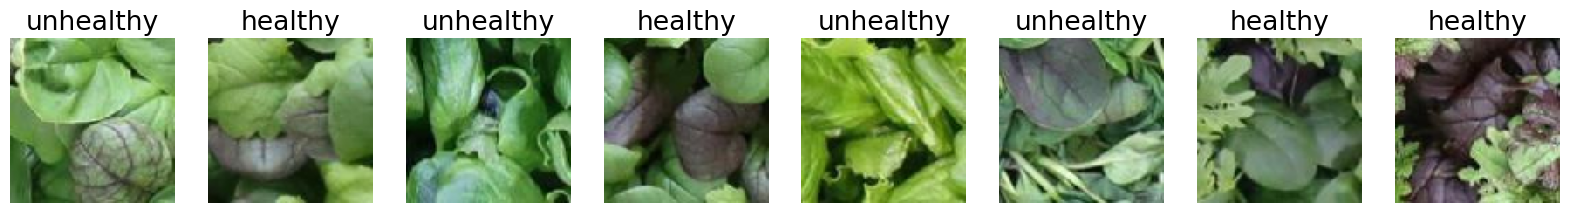

In [ ]:
# Randomize the choice of images at each run
seed = random.randint(0, 1000)
random.seed(seed)
fig, ax = plt.subplots(1, 8, figsize=(20, 20))
for i in range(8):
    random_index = random.randint(0, data_unique.shape[0])
    ax[i].imshow(data_unique[random_index])
    ax[i].set_title(labels_unique[random_index])
    ax[i].axis('off')
plt.show()

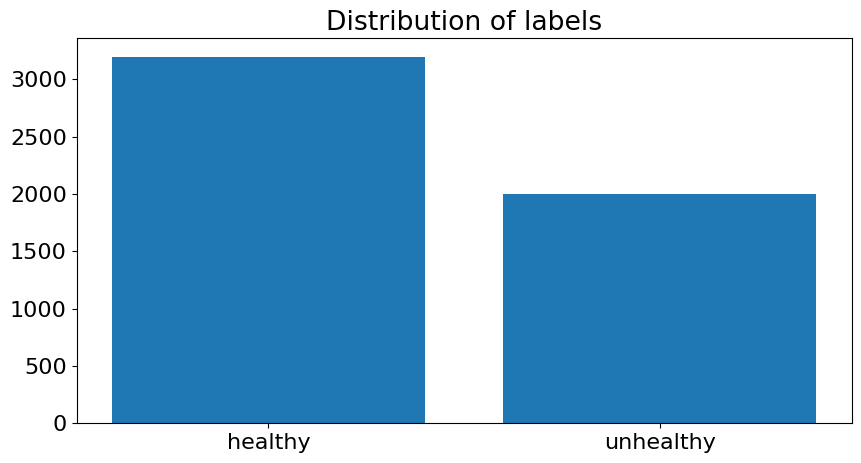

In [ ]:
# Plot the labels distribution

from collections import Counter

counter_labels = Counter(labels)
labels_count, counts = zip(*counter_labels.items())

plt.figure(figsize=(10, 5))
plt.bar(labels_count, counts)
plt.title('Distribution of labels')
plt.show()

In [ ]:
# BALANCING UNHEALTY IMAGES WITH MIXUP

import numpy as np
import tensorflow as tf


# Map textual labels to numeric values
label_mapping = {'healthy': 0, 'unhealthy': 1}
numeric_labels_original = np.array([label_mapping[label] for label in labels_unique])

# Find healthy and unhealthy image indexes
healthy_indices = np.where(numeric_labels_original == label_mapping['healthy'])[0]
unhealthy_indices = np.where(numeric_labels_original == label_mapping['unhealthy'])[0]


# Definition of the MixUp function
def mixup(image1, image2, label1, label2, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    mixed_image = lam * image1 + (1 - lam) * image2
    mixed_label = lam * label1 + (1 - lam) * label2
    return mixed_image, mixed_label


# Number of examples to generate for upsampling
num_to_generate = len(healthy_indices) - len(unhealthy_indices)


# Preparing new images and labels
new_images = []
new_labels = []

for _ in range(num_to_generate):
    idx_unhealthy_1 = np.random.choice(unhealthy_indices)
    idx_unhealthy_2 = np.random.choice(unhealthy_indices)


    unhealthy_img_1 = data_unique[idx_unhealthy_1]
    unhealthy_img_2 = data_unique[idx_unhealthy_2]

    unhealthy_label_1 = numeric_labels_original[idx_unhealthy_1]
    unhealthy_label_2 = numeric_labels_original[idx_unhealthy_2]


    # Apply MixUp
    mixed_img, mixed_label = mixup(unhealthy_img_1, unhealthy_label_2, unhealthy_label_1, unhealthy_label_2)

    # Rounds the mixed label to the nearest integer (0 or 1)
    mixed_label_rounded = np.round(mixed_label)

    # Add mixed (rounded) images and labels to new sets
    new_images.append(mixed_img)
    new_labels.append(mixed_label_rounded)


# Add the new images and labels to the original dataset
data_augmented = np.concatenate([data_unique, np.array(new_images)])
labels_augmented = np.concatenate([numeric_labels_original, np.array(new_labels).astype(np.int)])

print("Augmented data set size:", len(data_augmented))
print("Augmented labels size:", len(labels_augmented))


Dimensione dataset aumentato: 6120
Dimensione etichette aumentato: 6120


In [ ]:
#UPSAMPLING
# Suppose data_unique and labels_unique are already defined

# Find the indices of the healthy and unhealthy images
healthy_indices = np.where(labels_unique == 'healthy')[0]
unhealthy_indices = np.where(labels_unique == 'unhealthy')[0]

# Determine the number of images to sample from the unhealthy class to match the healthy class
num_samples = len(healthy_indices)

# Upsample the unhealthy class
if len(unhealthy_indices) < num_samples:
    unhealthy_upsampled_indices = np.random.choice(unhealthy_indices, size=num_samples, replace=True)
    new_indices = np.concatenate([healthy_indices, unhealthy_upsampled_indices])
else:
    new_indices = np.concatenate([healthy_indices, unhealthy_indices])

# Use the new indices to create your balanced dataset
data_balanced = data_unique[new_indices]
labels_balanced = labels_unique[new_indices]

# Function to count class instances
def count_classes(labels_to_count):
    unique, item_counts = np.unique(labels_to_count, return_counts=True)
    class_counts = dict(zip(unique, item_counts))
    return class_counts

# Count classes before upsampling
original_class_counts = count_classes(labels_unique)
print("Original class counts:", original_class_counts)

# Count classes after upsampling
upsampled_class_counts = count_classes(labels_balanced)
print("Upsampled class counts:", upsampled_class_counts)

# Check if the classes are balanced after upsampling
if len(set(upsampled_class_counts.values())) == 1:
    print("The classes are balanced.")
else:
    print("The classes are not balanced.")

# Assume that 'data_unique' is a Numpy array of images and 'labels_unique' are the corresponding labels
# Use the indices of the upsampled 'unhealthy' class to get the images to be augmented
upsampled_unhealthy_images = data_unique[unhealthy_upsampled_indices]

final_data_balanced = data_balanced


Original class counts: {'healthy': 3060, 'unhealthy': 1789}
Upsampled class counts: {'healthy': 3060, 'unhealthy': 3060}
The classes are balanced.


In [ ]:
# Convert labels to one-hot encoding
label_mapping = {'healthy': 0, 'unhealthy': 1}
numeric_labels = [label_mapping[label] for label in labels_augmented]
one_hot_labels = np.array(numeric_labels)

final_labels_balanced = one_hot_labels

print(len(one_hot_labels))
print(len(data_augmented))

In [ ]:
# Set class_weight if you want to train the model with weights on labels
n_samples = 3060 + 1789  # Total images
n_classes = 2  # "healty" and "unhealty"

weight_for_healty = n_samples / (n_classes * 3060)
weight_for_unhealty = n_samples / (n_classes * 1789)

class_weight = {0: weight_for_healty, 1: weight_for_unhealty}

# DATA SET SPLITTING

In [ ]:
# Split the unsampled data set with duplications
# Split the data into train_val and test sets with stratification to ensure that the distribution of labels is the same in both sets
train_val_data, test_data, train_val_labels, test_labels = train_test_split(data_augmented, labels_augmented, test_size=0.15, random_state=seed, stratify=labels_augmented)

# Further split the train_val set into train and val sets with stratification
train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=len(test_data), random_state=seed, stratify=train_val_labels)

# Print the shape of the train, val and test sets
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)
print(test_data.shape, test_labels.shape)




(4284, 96, 96, 3) (4284,)
(918, 96, 96, 3) (918,)
(918, 96, 96, 3) (918,)


In [ ]:
# Split the unsampled data set with mix up

from sklearn.model_selection import train_test_split
import numpy as np

# Definition of bins for labels
bins = np.array([0, 0.33, 0.66, 1])  # Definisce 3 bin
labels_binned = np.digitize(labels_augmented, bins) - 1  # Assign labels to bins

# Split the data into train_val and test sets with stratification based on bins
train_val_data, test_data, train_val_labels, test_labels = train_test_split(
    data_augmented, labels_augmented, test_size=0.15, random_state=seed, stratify=labels_binned)

# Further split the train_val set into train and val sets with stratification
train_data, val_data, train_labels, val_labels = train_test_split(
    train_val_data, train_val_labels, test_size=len(test_data), random_state=seed, stratify=np.digitize(train_val_labels, bins) - 1)

# Print the shape of the train, val, and test sets
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)
print(test_data.shape, test_labels.shape)


(4284, 96, 96, 3) (4284,)
(918, 96, 96, 3) (918,)
(918, 96, 96, 3) (918,)


#EFFICIENTNET MODEL

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None
)

base_model.trainable = False

preprocessing = tf.keras.Sequential([
    tf.keras.layers.Lambda(preprocess_input, input_shape=(96, 96, 3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
], name='preprocessing')

inputs = tfk.Input(shape=(96,96,3))

preprocessing = preprocessing(inputs)
x = tf.keras.layers.Resizing( 224, 224, interpolation='bilinear', crop_to_aspect_ratio=True,) (preprocessing)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.5, seed=seed)(x)
x = tfkl.Dense(
    1024,
    activation='leaky_relu')(x)

output_layer = tfkl.Dense(units=1, activation='sigmoid', name='Output')(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Freeze base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
learning_rate = 5e-4
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 4, factor= 0.5, min_lr= 5e-5, verbose=1)

callbacks = []

callbacks.append(rlrop)
callbacks.append(early_stopping)

In [ ]:
# Train the model
history = model.fit(
    x = train_data,
    y= train_labels,
    epochs = 200,
    validation_data = (val_data, val_labels),
    callbacks = callbacks,
).history

Epoch 1/200
134/134 [==============================] - 12s 87ms/step - loss: 0.4766 - accuracy: 0.7400 - precision: 0.7498 - recall: 0.5539 - val_loss: 0.4891 - val_accuracy: 0.7375 - val_precision: 0.8196 - val_recall: 0.4676 - lr: 5.0000e-05
Epoch 2/200
134/134 [==============================] - 11s 82ms/step - loss: 0.4812 - accuracy: 0.7388 - precision: 0.7592 - recall: 0.5331 - val_loss: 0.4801 - val_accuracy: 0.7527 - val_precision: 0.7701 - val_recall: 0.5912 - lr: 5.0000e-05
Epoch 3/200
134/134 [==============================] - 11s 82ms/step - loss: 0.4846 - accuracy: 0.7358 - precision: 0.7513 - recall: 0.5470 - val_loss: 0.4821 - val_accuracy: 0.7516 - val_precision: 0.8108 - val_recall: 0.5294 - lr: 5.0000e-05
Epoch 4/200
134/134 [==============================] - 11s 86ms/step - loss: 0.4833 - accuracy: 0.7425 - precision: 0.7562 - recall: 0.5558 - val_loss: 0.4824 - val_accuracy: 0.7484 - val_precision: 0.7906 - val_recall: 0.5441 - lr: 5.0000e-05
Epoch 5/200
134/134 [===

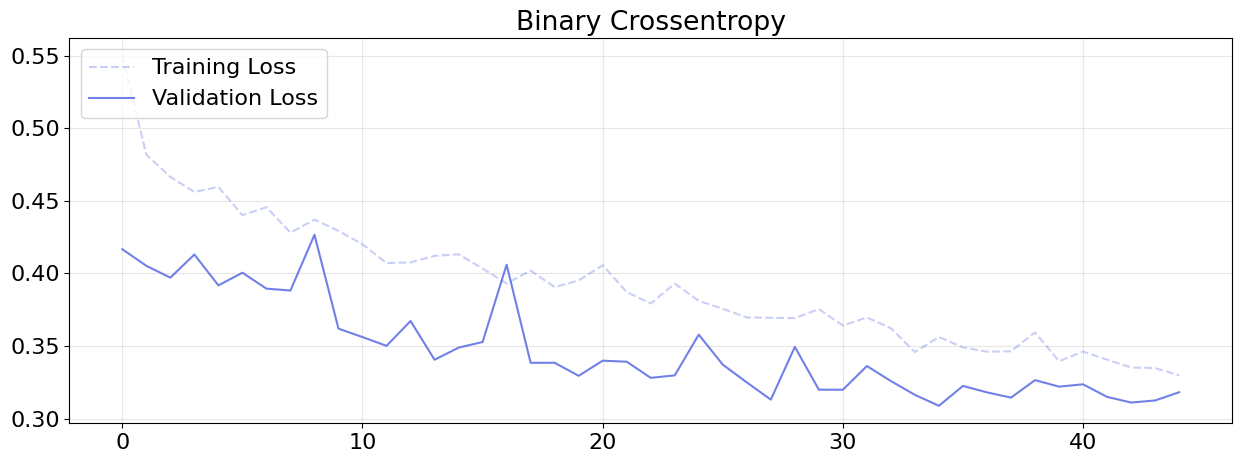

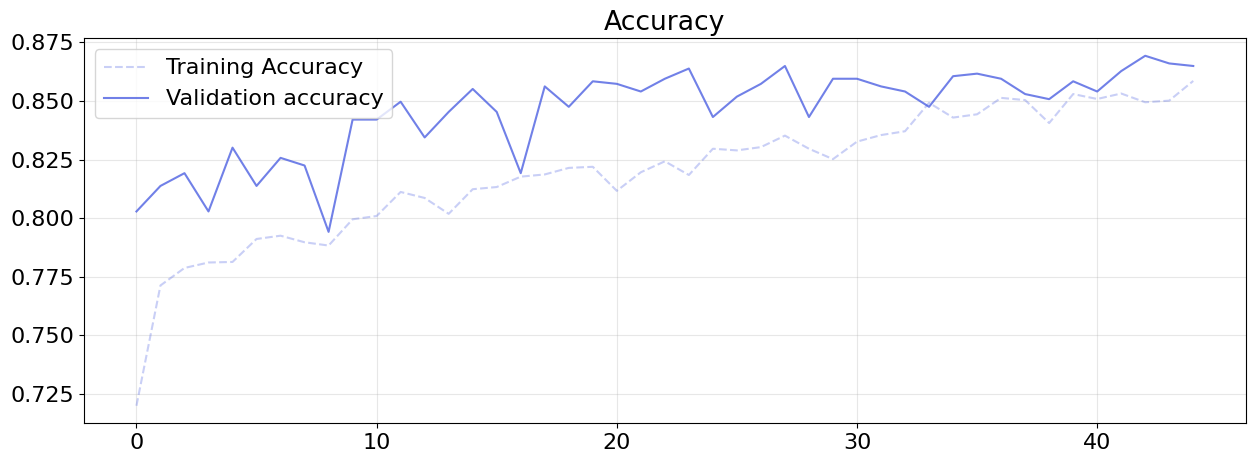

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the best model
model.save('EfficientNet')

In [ ]:
# Re-load the model after transfer learning
model = tfk.models.load_model('EfficientNet')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39 

In [ ]:
# Set all layers to Trainable
model.get_layer('efficientnetb0').trainable = True
for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
   print(i, layer.name, layer.trainable)


0 input_1 True
1 rescaling True
2 normalization True
3 rescaling_1 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b_se_

In [ ]:
#FINETUNING BLOCKs 6, 7
for i, layer in enumerate(model.get_layer('efficientnetb0').layers[:163]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    loss=tfk.losses.BinaryCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-5),  # a lower learning rate for fine-tuning
    metrics=['accuracy']
)

In [ ]:
# Continue training with fine-tuning
history_fine_tune = model.fit(
    x = train_data,
    y = train_labels,
    epochs = 250,
    validation_data = (val_data, val_labels),
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
).history

In [ ]:
# Save the best model
model.save('/content/drive/MyDrive/EfficientNet_fine_tuned_mix_up')

In [ ]:
# Re-load the model after fine tuning
tl_model = tfk.models.load_model('/content/drive/MyDrive/EfficientNet_fine_tuned_mix_up')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
# Assign the evaluation results to metrics varables
loss, accuracy = tl_model.evaluate(test_data, test_labels)

# Print the metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


29/29 [==============================] - 7s 68ms/step - loss: 0.2115 - accuracy: 0.9194
Loss: 0.21146871149539948
Accuracy: 0.9193899631500244


In [ ]:
# Obtain the predicted values by the model
predictions = tl_model.predict(test_data)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Obtain labels as 0 or 1 for binary classification
predicted_classes = np.where(predictions > 0.5, 1, 0)

29/29 [==============================] - 4s 66ms/step
Predictions Shape: (918, 1)


[[492  28]
 [ 46 352]]


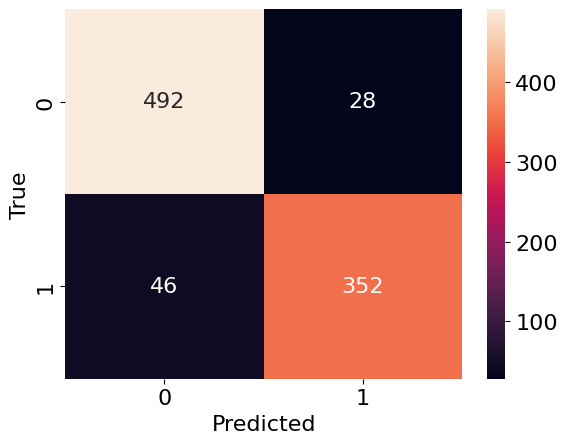

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Print the confusion matrix
print(conf_matrix)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Calculate and print the classification report
report = classification_report(test_labels, predicted_classes)
print(report)


              precision    recall  f1-score   support

           0       0.91      0.95      0.93       520
           1       0.93      0.88      0.90       398

    accuracy                           0.92       918
   macro avg       0.92      0.92      0.92       918
weighted avg       0.92      0.92      0.92       918



#NEW MODEL TRAINED ON AUGMENTED AND BALANCED DATA SET WITH MISPREDICTED IMAGES

## MISPREDICTED DATA SET PREPARATION

In [ ]:
mispredicted_images_test = []
mispredicted_labels_test = []

for i in range(len(test_labels)):

    # Check if the prediction is different from the actual label
    if predicted_classes[i] != test_labels[i]:
        mispredicted_images_test.append(test_data[i])
        label_str = 'healthy' if test_labels[i] == 0 else 'unhealthy'
        mispredicted_labels_test.append(label_str)

In [ ]:
# Count classes before upsampling
class_counts = count_classes(mispredicted_labels_test)
print("Mispredicted:", class_counts)

Mispredicted: {'healthy': 9, 'unhealthy': 60}


In [ ]:
# Assign the evaluation results to metrics varables
loss, accuracy, precision, recall = tl_model.evaluate(val_data, val_labels)

# Print the metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

29/29 [==============================] - 2s 61ms/step - loss: 0.2753 - accuracy: 0.9172 - precision_4: 0.9898 - recall_4: 0.8431
Loss: 0.27531707286834717
Accuracy: 0.9172113537788391
Precision: 0.9897698163986206
Recall: 0.843137264251709


In [ ]:
# Obtain the predicted values by the model
predictions = tl_model.predict(val_data)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Obtain labels as 0 or 1 for binary classification
predicted_classes = np.where(predictions > 0.5, 1, 0)

29/29 [==============================] - 2s 56ms/step
Predictions Shape: (918, 1)


[[455   4]
 [ 72 387]]


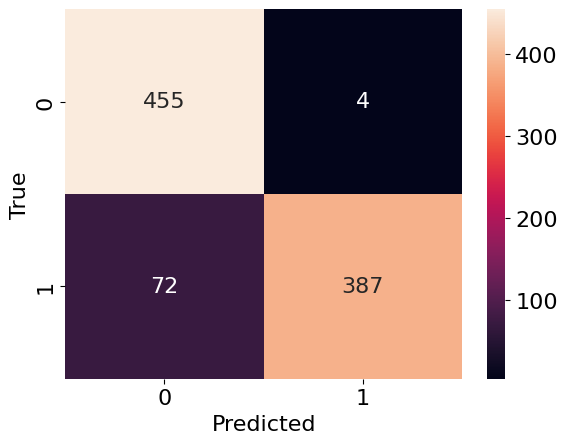

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(val_labels, predicted_classes)

# Print the confusion matrix
print(conf_matrix)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Calculate and print the classification report
report = classification_report(val_labels, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       459
           1       0.99      0.84      0.91       459

    accuracy                           0.92       918
   macro avg       0.93      0.92      0.92       918
weighted avg       0.93      0.92      0.92       918



In [ ]:
mispredicted_images_val = []
mispredicted_labels_val = []

for i in range(len(test_labels)):
    # Check if the prediction is different from the actual label
    if predicted_classes[i] != val_labels[i]:
        mispredicted_images_val.append(val_data[i])
        label_str = 'healthy' if val_labels[i] == 0 else 'unhealthy'
        mispredicted_labels_val.append(label_str)

In [ ]:
# Count classes before upsampling
class_counts = count_classes(mispredicted_labels_val)
print("Mispredicted:", class_counts)

Mispredicted: {'healthy': 4, 'unhealthy': 72}


In [ ]:
# Assign the evaluation results to metrics varables
loss, accuracy, precision, recall = tl_model.evaluate(train_data, train_labels)

# Print the metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

134/134 [==============================] - 9s 64ms/step - loss: 0.2042 - accuracy: 0.9386 - precision_4: 0.9932 - recall_4: 0.8833
Loss: 0.20422254502773285
Accuracy: 0.9386087656021118
Precision: 0.9931758642196655
Recall: 0.8832866549491882


In [ ]:
# Obtain the predicted values by the model
predictions = tl_model.predict(train_data)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Obtain labels as 0 or 1 for binary classification
predicted_classes = np.where(predictions > 0.5, 1, 0)

134/134 [==============================] - 8s 60ms/step
Predictions Shape: (4284, 1)


[[2129   13]
 [ 250 1892]]


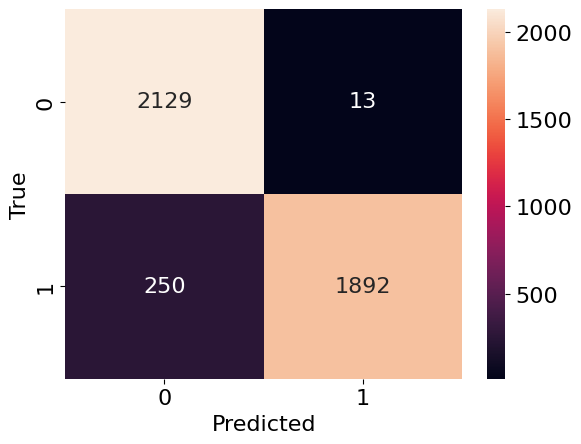

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(train_labels, predicted_classes)

# Print the confusion matrix
print(conf_matrix)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Calculate and print the classification report
report = classification_report(train_labels, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2142
           1       0.99      0.88      0.94      2142

    accuracy                           0.94      4284
   macro avg       0.94      0.94      0.94      4284
weighted avg       0.94      0.94      0.94      4284



In [ ]:
mispredicted_images_train = []
mispredicted_labels_train = []

for i in range(len(train_labels)):
    # Check if the prediction is different from the actual label
    if predicted_classes[i] != train_labels[i]:
        mispredicted_images_train.append(train_data[i])
        label_str = 'healthy' if train_labels[i] == 0 else 'unhealthy'
        mispredicted_labels_train.append(label_str)

In [ ]:
# Count classes before upsampling
class_counts = count_classes(mispredicted_labels_train)
print("Mispredicted:", class_counts)

Mispredicted: {'healthy': 13, 'unhealthy': 250}


In [ ]:
mispredicted_images = []
mispredicted_labels = []

mispredicted_images = np.concatenate([mispredicted_images_test, mispredicted_images_val, mispredicted_images_train])
mispredicted_labels = np.concatenate([mispredicted_labels_test, mispredicted_labels_val, mispredicted_labels_train])



In [ ]:
# Count classes before upsampling
class_counts = count_classes(mispredicted_labels)
print("Mispredicted:", class_counts)

Mispredicted: {'healthy': 26, 'unhealthy': 382}


##DATA SET PREPARATION WITH MISPREDICTIONS

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageEnhance


# Number of augmented versions for each image
augmentation_factor = 3


# List for augmented images and their labels
augmented_images = []
augmented_labels = []


# Create a data augmentation generator
data_gen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest'
)

for img, label in zip(mispredicted_images, mispredicted_labels):
    for _ in range(augmentation_factor):
        # Apply augmentation
        img_aug = data_gen.random_transform(img)
        augmented_images.append(img_aug)
        augmented_labels.append(label)


# Convert lists to arrays (if necessary) and add them to the original datasets
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(len(augmented_images))
print(len(augmented_labels))

data_unique = np.concatenate([data_unique, augmented_images])
labels_unique = np.concatenate([labels_unique, augmented_labels])

print(len(data_unique))
print(len(labels_unique))



1224
1224
6073
6073


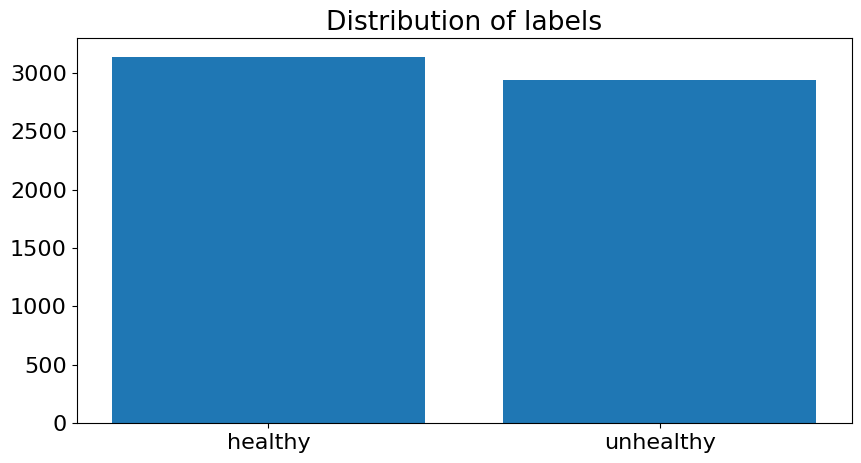

In [ ]:
# Plot the labels distribution

from collections import Counter

counter_labels = Counter(labels_unique)
labels_count, counts = zip(*counter_labels.items())

plt.figure(figsize=(10, 5))
plt.bar(labels_count, counts)
plt.title('Distribution of labels')
plt.show()

In [ ]:
# Convert labels to one-hot encoding
label_mapping = {'healthy': 0, 'unhealthy': 1}
numeric_labels = [label_mapping[label] for label in labels_unique]
one_hot_labels = np.array(numeric_labels)


print(len(one_hot_labels))
print(len(data_unique))

6073
6073


##DATA SET SPLITTING

In [ ]:
# Split the data into train_val and test sets with stratification to ensure that the distribution of labels is the same in both sets
train_val_data, test_data, train_val_labels, test_labels = train_test_split(data_unique, one_hot_labels, test_size=0.15, random_state=seed, stratify=one_hot_labels)

# Further split the train_val set into train and val sets with stratification
train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=len(test_data), random_state=seed, stratify=train_val_labels)

# Print the shape of the train, val and test sets
print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)
print(test_data.shape, test_labels.shape)

(4251, 96, 96, 3) (4251,)
(911, 96, 96, 3) (911,)
(911, 96, 96, 3) (911,)


##EFFICIENTNET MODEL ON MISPREDICTED

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None
)

base_model.trainable = False

preprocessing = tf.keras.Sequential([
    tf.keras.layers.Lambda(preprocess_input, input_shape=(96, 96, 3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
], name='preprocessing')

inputs = tfk.Input(shape=(96,96,3))

preprocessing = preprocessing(inputs)
x = tf.keras.layers.Resizing( 224, 224, interpolation='bilinear', crop_to_aspect_ratio=True,) (preprocessing)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.5, seed=seed)(x)
x = tfkl.Dense(
    1024,
    activation='leaky_relu')(x)

output_layer = tfkl.Dense(units=1, activation='sigmoid', name='Output')(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')


# Freeze base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
learning_rate = 5e-4
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Set the learning rate here
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Train the model
history = model.fit(
    x = train_data,
    y= train_labels,
    epochs = 200,
    batch_size =32,
    validation_data = (val_data, val_labels),
    callbacks = callbacks,
).history

Epoch 1/200
133/133 [==============================] - 12s 90ms/step - loss: 0.3486 - accuracy: 0.8485 - precision: 0.8508 - recall: 0.8326 - val_loss: 0.3502 - val_accuracy: 0.8463 - val_precision: 0.9286 - val_recall: 0.7386 - lr: 5.0000e-05
Epoch 2/200
133/133 [==============================] - 12s 87ms/step - loss: 0.3659 - accuracy: 0.8353 - precision: 0.8434 - recall: 0.8097 - val_loss: 0.3366 - val_accuracy: 0.8474 - val_precision: 0.9169 - val_recall: 0.7523 - lr: 5.0000e-05
Epoch 3/200
133/133 [==============================] - 11s 86ms/step - loss: 0.3476 - accuracy: 0.8490 - precision: 0.8563 - recall: 0.8263 - val_loss: 0.3151 - val_accuracy: 0.8738 - val_precision: 0.9012 - val_recall: 0.8295 - lr: 5.0000e-05
Epoch 4/200
133/133 [==============================] - 10s 77ms/step - loss: 0.3602 - accuracy: 0.8429 - precision: 0.8455 - recall: 0.8258 - val_loss: 0.3199 - val_accuracy: 0.8672 - val_precision: 0.9143 - val_recall: 0.8000 - lr: 5.0000e-05
Epoch 5/200
133/133 [===

In [ ]:
# Save the best model
model.save('/content/drive/MyDrive/Challenge1/EfficientNetXXX')

In [ ]:
# Re-load the model
model = tfk.models.load_model('/content/drive/MyDrive/Challenge1/EfficientNetXXX')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0     

In [ ]:
for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39 

In [ ]:
# Set all layers to Trainable
model.get_layer('efficientnetb0').trainable = True
for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 rescaling True
2 normalization True
3 rescaling_1 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2b_se_

In [ ]:
#FINETUNING BLOCKs 6, 7
for i, layer in enumerate(model.get_layer('efficientnetb0').layers[:163]):
  layer.trainable=False
for i, layer in enumerate(model.get_layer('efficientnetb0').layers):
   print(i, layer.name, layer.trainable)
model.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Ricompila il modello con un learning rate più basso per il fine-tuning
model.compile(
    loss=tfk.losses.BinaryCrossentropy(),
    optimizer=tfk.optimizers.Adam(learning_rate=1e-5),  # un learning rate più basso per il fine-tuning
    metrics=['accuracy']
)

In [ ]:
# Continue training with fine-tuning
history_fine_tune = model.fit(
    x = train_data,
    y = train_labels,
    epochs = 130,
    batch_size = 32,
    validation_data = (val_data, val_labels),
    callbacks = callbacks,
).history

Epoch 1/130
133/133 [==============================] - 37s 132ms/step - loss: 0.3087 - accuracy: 0.8654 - val_loss: 0.3178 - val_accuracy: 0.8661 - lr: 1.0000e-05
Epoch 2/130
133/133 [==============================] - 15s 112ms/step - loss: 0.2992 - accuracy: 0.8789 - val_loss: 0.2940 - val_accuracy: 0.8738 - lr: 1.0000e-05
Epoch 3/130
133/133 [==============================] - 15s 112ms/step - loss: 0.2791 - accuracy: 0.8819 - val_loss: 0.2790 - val_accuracy: 0.8880 - lr: 1.0000e-05
Epoch 4/130
133/133 [==============================] - 15s 113ms/step - loss: 0.2921 - accuracy: 0.8720 - val_loss: 0.2889 - val_accuracy: 0.8804 - lr: 1.0000e-05
Epoch 5/130
133/133 [==============================] - 15s 112ms/step - loss: 0.2709 - accuracy: 0.8831 - val_loss: 0.2956 - val_accuracy: 0.8639 - lr: 1.0000e-05
Epoch 6/130
133/133 [==============================] - 15s 113ms/step - loss: 0.2667 - accuracy: 0.8890 - val_loss: 0.2623 - val_accuracy: 0.8891 - lr: 1.0000e-05
Epoch 7/130
133/133 [=

In [ ]:
# Save the best model
model.save('/content/drive/MyDrive/Challenge1/EfficientNetXXX_fine_tuned')

#SAME MODEL WITH SECOND FINE-TUNING ON MISPREDICTED IMAGES

## MISPREDICTED DATA SET PREPARATION

In [ ]:
mispredicted_images = []
mispredicted_labels = []

for i in range(len(test_labels)):
    # Check if the prediction is different from the actual label
    if predicted_classes[i] != test_labels[i]:
        mispredicted_images.append(test_data[i])
        mispredicted_labels.append(test_labels[i])

In [ ]:
import numpy as np
import random

correctly_predicted_images = []
correctly_predicted_labels = []


# Identify correctly classified images
for i in range(len(test_labels)):
    if predicted_classes[i] == test_labels[i]:
        correctly_predicted_images.append(test_data[i])
        correctly_predicted_labels.append(test_labels[i])

# Choose a random number of indices from the corrected images
num_images_to_add = 80
selected_indices = random.sample(range(len(correctly_predicted_images)), num_images_to_add)

# Create numpy arrays for the selected images and their labels
subset_correctly_predicted_images = np.array([correctly_predicted_images[i] for i in selected_indices])
subset_correctly_predicted_labels = np.array([correctly_predicted_labels[i] for i in selected_indices])


In [ ]:

# Prepare the mini-dataset for training
X_train_mini = np.concatenate((mispredicted_images, subset_correctly_predicted_images))
y_train_mini = np.concatenate((mispredicted_labels, subset_correctly_predicted_labels))

In [ ]:
import numpy as np

# Split dataset by class
class_0_indices = np.where(y_train_mini == 0)[0]
class_1_indices = np.where(y_train_mini == 1)[0]

X_class_0 = X_train_mini[class_0_indices]
X_class_1 = X_train_mini[class_1_indices]
y_class_0 = y_train_mini[class_0_indices]
y_class_1 = y_train_mini[class_1_indices]


# Determine which class needs upsampling
num_to_augment = max(len(class_0_indices), len(class_1_indices)) - min(len(class_0_indices), len(class_1_indices))
class_to_augment = 0 if len(class_0_indices) < len(class_1_indices) else 1

# Do upsampling
if class_to_augment == 0:
    indices_to_add = np.random.choice(class_0_indices, num_to_augment)
    X_class_0_upsampled = np.concatenate((X_class_0, X_train_mini[indices_to_add]))
    y_class_0_upsampled = np.concatenate((y_class_0, y_train_mini[indices_to_add]))
    X_train_balanced = np.concatenate((X_class_0_upsampled, X_class_1))
    y_train_balanced = np.concatenate((y_class_0_upsampled, y_class_1))
else:
    indices_to_add = np.random.choice(class_1_indices, num_to_augment)
    X_class_1_upsampled = np.concatenate((X_class_1, X_train_mini[indices_to_add]))
    y_class_1_upsampled = np.concatenate((y_class_1, y_train_mini[indices_to_add]))
    X_train_balanced = np.concatenate((X_class_0, X_class_1_upsampled))
    y_train_balanced = np.concatenate((y_class_0, y_class_1_upsampled))

# Shuffle final data set
indices = np.arange(len(y_train_balanced))
np.random.shuffle(indices)

X_train_balanced = X_train_balanced[indices]
y_train_balanced = y_train_balanced[indices]


## SECOND FINE-TUNING

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


# Compile the model
tl_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tuning on mini data set
tl_model.fit(x = X_train_balanced, y = y_train_balanced , batch_size=32, epochs=100, validation_split=0.2, callbacks = callbacks)

Epoch 1/100
5/5 [==============================] - 25s 1s/step - loss: 0.2578 - accuracy: 0.8716 - val_loss: 0.4510 - val_accuracy: 0.7895 - lr: 1.0000e-04
Epoch 2/100
5/5 [==============================] - 1s 152ms/step - loss: 0.2178 - accuracy: 0.9257 - val_loss: 0.2609 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 3/100
5/5 [==============================] - 1s 117ms/step - loss: 0.1720 - accuracy: 0.9324 - val_loss: 0.3462 - val_accuracy: 0.7895 - lr: 1.0000e-04
Epoch 4/100
5/5 [==============================] - 1s 134ms/step - loss: 0.1171 - accuracy: 0.9527 - val_loss: 0.2858 - val_accuracy: 0.7895 - lr: 1.0000e-04
Epoch 5/100
5/5 [==============================] - 1s 137ms/step - loss: 0.0877 - accuracy: 0.9730 - val_loss: 0.2838 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 6/100
5/5 [==============================] - 1s 159ms/step - loss: 0.0590 - accuracy: 0.9797 - val_loss: 0.2569 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 7/100
5/5 [==============================] - 1s 

In [ ]:
# Save the model
tl_model.save('/content/drive/MyDrive/Challenge1/EfficientNetXXX1_fine_tuning1_mispredicted')

In [ ]:
# Re-load the model
model = tfk.models.load_model('EfficientNet_mispredicted')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0     

In [ ]:

# Assign all values ​​returned by the evaluate to their corresponding variables
loss, accuracy, precision, recall = model.evaluate(final_data_balanced, final_labels_balanced)


# Print metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

ValueError: ignored

In [ ]:

# Get the values ​​predicted by the model
predictions = tl_model.predict(final_data_balanced)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)


# For binary classification, you may want to get the labels as 0 or 1
predicted_classes = np.where(predictions > 0.5, 1, 0)

192/192 [==============================] - 12s 60ms/step
Predictions Shape: (6120, 1)


[[3017   43]
 [ 160 2900]]


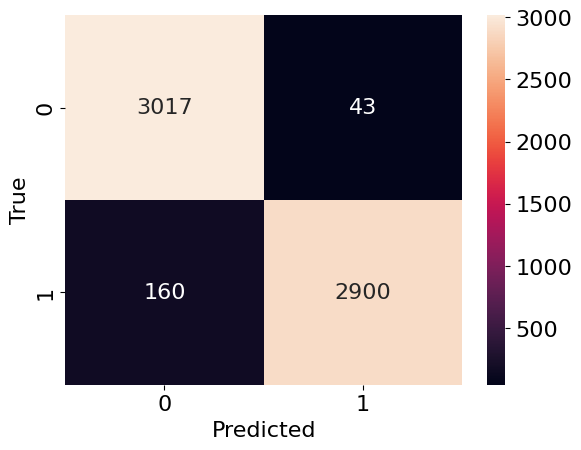

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(final_labels_balanced, predicted_classes)

# Print the confusion matrix
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()